In [3]:
# imports
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import LSTM, Bidirectional

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import gc

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
# Load data from the npz file
data = np.load('/home/ndo/bash_output/encoded_sequences/onehot_endcoding.npz')
sequences = data['encoded_sequences']
labels = data['input_labels']

sequences.shape, labels.shape

((4780080, 201, 4), (4780080, 2))

In [5]:
# How many items per class?
from collections import Counter

# numpy arrays to tuples
labels_tuples = [tuple(label) for label in labels]

# Calculate the counts using Counter
label_counts = Counter(labels_tuples)
print(label_counts)

# Calculate the proportions
proportions = [count / sum(label_counts.values()) for count in label_counts.values()]
print(proportions)

Counter({(0, 1): 3170893, (1, 0): 1609187})
[0.663355634215327, 0.33664436578467305]


In [5]:
sequences.shape
labels

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [1, 0]], dtype=int8)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 804)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       103,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,298 (403.51 KB)

 Trainable params: 103,298 (403.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.6626 - loss: 0.6360 - val_accuracy: 0.6681 - val_loss: 0.6229
Epoch 2/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6704 - loss: 0.6208 - val_accuracy: 0.6732 - val_loss: 0.6183
Epoch 3/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6742 - loss: 0.6162 - val_accuracy: 0.6740 - val_loss: 0.6172
Epoch 4/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6753 - loss: 0.6136 - val_accuracy: 0.6742 - val_loss: 0.6171
Epoch 5/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6763 - loss: 0.6115 - val_accuracy: 0.6740 - val_loss: 0.6172
Epoch 6/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6774 - loss: 0.6098 - val_accuracy: 0.6731 - val_loss: 0.6177
Epoch 7/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6785 - loss: 0.6079 - val_accuracy: 0.6722 - val_loss: 0.6183
Epoch 8/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6794 - loss: 0.6064 - val_accuracy: 

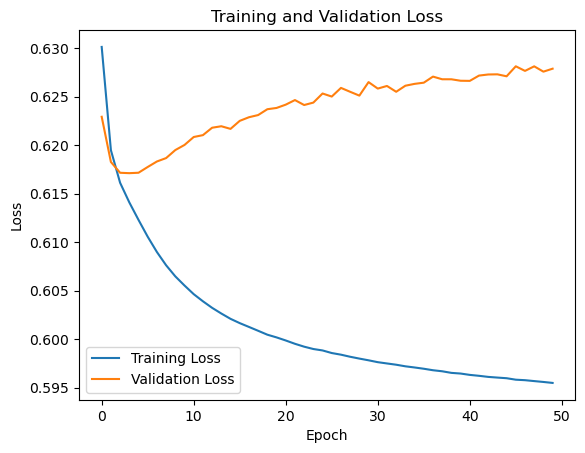

In [6]:
# basic MLP (1 hidden layer, 128 nodes)
tf.keras.backend.clear_session()
gc.collect()

# create model
model = Sequential([
    Input(shape=(201, 4)), 
    Flatten(), 
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model with appropriate loss and optimizer
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),  # tunable hyperparameter: learning rate
              metrics=['accuracy'])

model.summary()

# Fit the model
history = model.fit(sequences, labels, 
                    epochs=50, 
                    batch_size=2**12, 
                    validation_split=0.2)  # tunable hyperparameters: batch size and epochs

# Create a DataFrame from the training history
history_df = pd.DataFrame(history.history)

# Display the table
print(history_df)

# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Define DNNA model
def create_dnna_model(input_shape):
    model = models.Sequential()

    # Three layers of depthwise separable convolutions
    model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.DepthwiseConv1D(kernel_size=3, activation='relu'))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.DepthwiseConv1D(kernel_size=3, activation='relu'))
    model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))

    # Pooling layer
    model.add(layers.GlobalAveragePooling1D())

    # Fully connected layers
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Generate dummy data
input_data = np.random.randint(2, size=(4000, 201, 4))


# Create DNNA model
input_shape = (201, 4)
model = create_dnna_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
model.fit(input_data, labels, epochs=10, batch_size=32, validation_split=0.2)


/home/ndo/miniconda3/envs/notebook/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 199, 32)        │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv1d                │ (None, 197, 32)        │           128 │
│ (DepthwiseConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 195, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv1d_1              │ (None, 193, 64)        │           256 │
│ (DepthwiseConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 191, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,081 (164.38 KB)

 Trainable params: 42,081 (164.38 KB)

 Non-trainable params: 0 (0.00 B)

NameError: name 'labels' is not defined

In [6]:
labels_test = np.random.randint(2, size=(4000, 1))
labels_test

# labels

array([[0],
       [0],
       [1],
       ...,
       [1],
       [0],
       [0]])

The number of nodes in the first hidden layer is increased to 256 to capture more complex patterns in the data.
Dropout regularization layers with a dropout rate of 0.5 are added after each dense layer to prevent overfitting by randomly dropping out a fraction of the neurons during training.
An additional hidden layer with 64 nodes is added to the model to provide more capacity for learning complex relationships in the data.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 804)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       206,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,362 (966.26 KB)

 Trainable params: 247,362 (966.26 KB)

 Non-trainable params: 0 (0.00 B)

2024-03-22 11:47:37.253353: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3074547456 exceeds 10% of free system memory.


Epoch 1/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.6621 - loss: 0.6385 - val_accuracy: 0.6654 - val_loss: 0.6301
Epoch 2/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.6643 - loss: 0.6269 - val_accuracy: 0.6682 - val_loss: 0.6259
Epoch 3/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.6680 - loss: 0.6228 - val_accuracy: 0.6713 - val_loss: 0.6232
Epoch 4/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.6694 - loss: 0.6208 - val_accuracy: 0.6728 - val_loss: 0.6222
Epoch 5/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.6698 - loss: 0.6199 - val_accuracy: 0.6738 - val_loss: 0.6212
Epoch 6/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.6707 - loss: 0.6185 - val_accuracy: 0.6739 - val_loss: 0.6202
Epoch 7/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.6709 - loss: 0.6181 - val_accuracy: 0.6731 - val_loss: 0.6207
Epoch 8/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.6713 - loss: 0.6174 - 

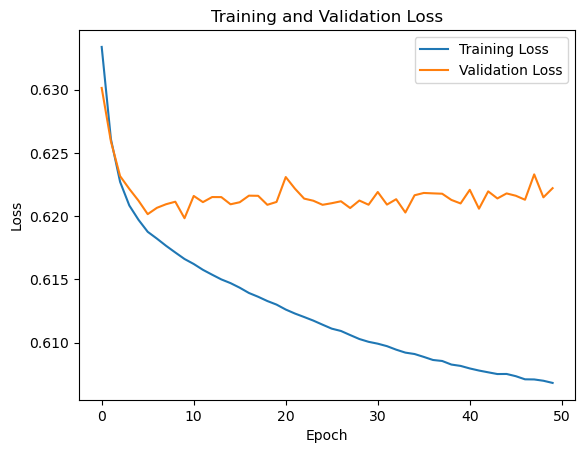

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam
import gc

# Clear previous session to free up memory
tf.keras.backend.clear_session()
gc.collect()

# Define the model with regularization and adjusted architecture
model = Sequential([
    Input(shape=(201, 4)),
    Flatten(),
    Dense(256, activation='relu'),  # Increased nodes in the hidden layer
    Dropout(0.5),  # Dropout regularization
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout regularization
    Dense(64, activation='relu'),  # Adding another hidden layer
    Dense(2, activation='softmax')
])

# Compile the model with appropriate loss and optimizer
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

# Fit the model
history = model.fit(sequences, labels, 
                    epochs=50, 
                    batch_size=2**12, 
                    validation_split=0.2)

# Create a DataFrame from the training history
history_df = pd.DataFrame(history.history)

# Display the table
print(history_df)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

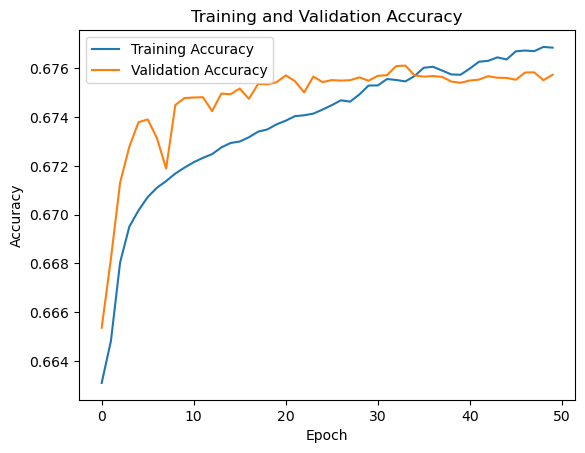

In [14]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 804)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       412,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 584,770 (2.23 MB)

 Trainable params: 584,770 (2.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


2024-03-25 09:40:47.406458: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3074547456 exceeds 10% of free system memory.


934/934 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.6534 - loss: 0.6541 - val_accuracy: 0.6640 - val_loss: 0.6437
Epoch 2/100
934/934 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6636 - loss: 0.6364 - val_accuracy: 0.6640 - val_loss: 0.6391
Epoch 3/100
934/934 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6636 - loss: 0.6325 - val_accuracy: 0.6640 - val_loss: 0.6370
Epoch 4/100
934/934 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6632 - loss: 0.6306 - val_accuracy: 0.6640 - val_loss: 0.6350
Epoch 5/100
934/934 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6631 - loss: 0.6288 - val_accuracy: 0.6645 - val_loss: 0.6335
Epoch 6/100
934/934 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.6637 - loss: 0.6269 - val_accuracy: 0.6656 - val_loss: 0.6314
Epoch 7/100
934/934 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6643 - loss: 0.6253 - val_accuracy: 0.6663 - val_loss: 0.6295
Epoch 8/100
934/934 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6654 - loss: 0.6235 - val_

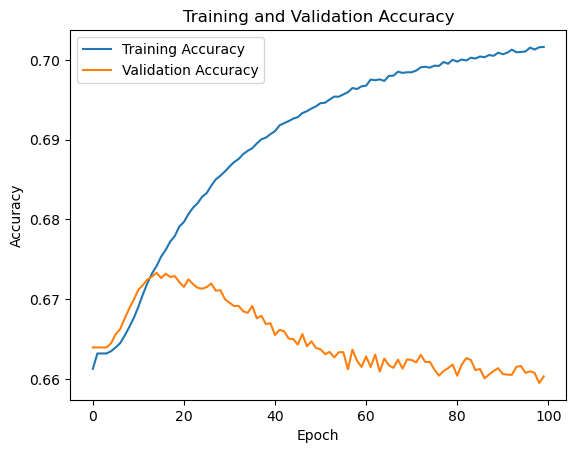

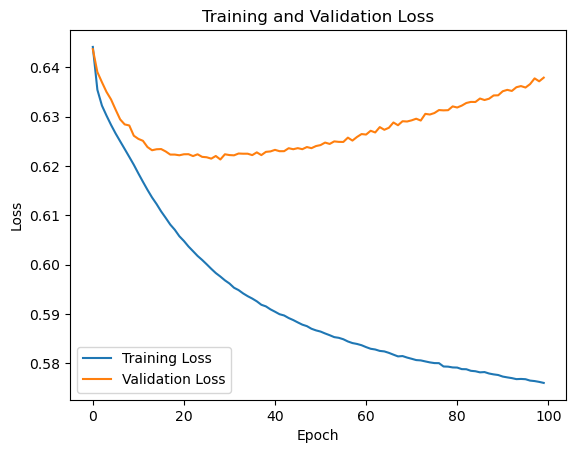

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam
import gc

# Clear previous session to free up memory
tf.keras.backend.clear_session()
gc.collect()

# Define the model with regularization and adjusted architecture
model = Sequential([
    Input(shape=(201, 4)),
    Flatten(),
    Dense(512, activation='relu'),  # Increased nodes in the hidden layer
    Dropout(0.5),  # Dropout regularization
    Dense(256, activation='relu'),  # Increased nodes in the hidden layer
    Dropout(0.5),  # Dropout regularization
    Dense(128, activation='relu'),  # Increased nodes in the hidden layer
    Dropout(0.5),  # Dropout regularization
    Dense(64, activation='relu'),  # Adding another hidden layer
    Dense(2, activation='softmax')
])

# Compile the model with appropriate loss and optimizer
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),  # Adjusting learning rate
              metrics=['accuracy'])

model.summary()

# Fit the model
history = model.fit(sequences, labels, 
                    epochs=100,  # Increased epochs
                    batch_size=2**12, 
                    validation_split=0.2)

# Create a DataFrame from the training history
history_df = pd.DataFrame(history.history)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()